/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Loading model and tokenizer...
Model loaded successfully.
Running experiment for 'unconstrained' case...
'unconstrained' case finished. Final similarity: 0.9865
Running experiment for 'corner' case...
'corner' case finished. Final similarity: 0.3363


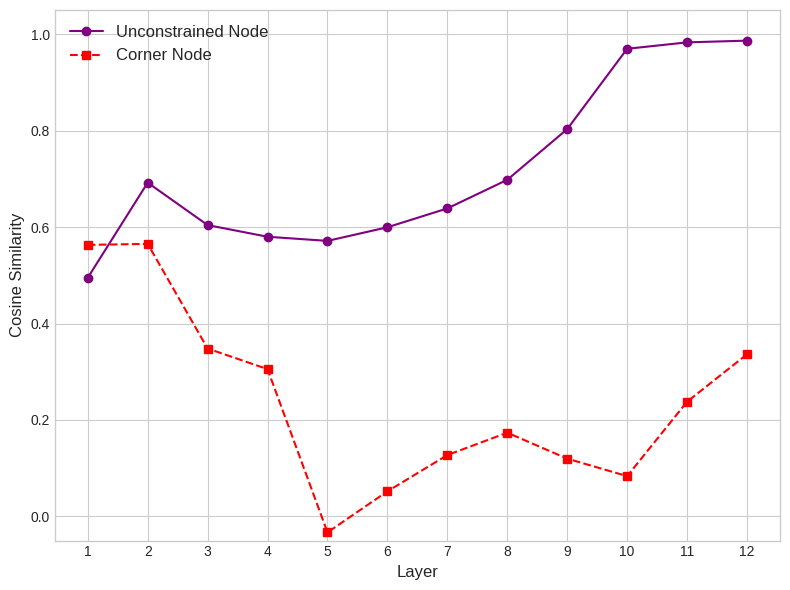

In [ ]:
# Direction Swapping Experiment
# Test functional map validation by swapping directions in walk history

import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import networkx as nx

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model/checkpoint-33000"
GRID_SIZE = 4
WALK_LENGTH = 100

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

def generate_grid_graph(size=4):
    """Generates a grid graph with coordinate metadata."""
    G = nx.DiGraph()
    nodes = [f"{chr(97+r)}{chr(97+c)}" for r in range(size) for c in range(size)]
    direction_map = {'N': 'NORTH', 'S': 'SOUTH', 'E': 'EAST', 'W': 'WEST'}
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            G.add_node(nodes[idx], coords=(r, c))
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx+1], direction=direction_map['E'])
            if c > 0: G.add_edge(nodes[idx], nodes[idx-1], direction=direction_map['W'])
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx+size], direction=direction_map['S'])
            if r > 0: G.add_edge(nodes[idx], nodes[idx-size], direction=direction_map['N'])
    return G

def generate_random_walk(G, start_node, length):
    path = [start_node]
    for _ in range(length - 1):
        neighbors = list(G.successors(path[-1]))
        if not neighbors: break
        path.append(random.choice(neighbors))
    return path

def walk_to_string(walk, G):
    if not walk or len(walk) < 2: return walk[0] if walk else ""
    parts = [f"{walk[i]} {G.edges[walk[i], walk[i+1]]['direction']}" for i in range(len(walk) - 1)]
    return " ".join(parts) + f" {walk[-1]}"

def swap_directions_robust(prompt):
    swap_map = {'NORTH': 'SOUTH', 'SOUTH': 'NORTH', 'EAST': 'WEST', 'WEST': 'EAST'}
    return ' '.join([swap_map.get(part, part) for part in prompt.split(' ')])

def get_hidden_states(model, tokens):
    cache = {}
    hooks = []
    def save_hook(layer_idx):
        def hook_fn(module, input, output):
            cache[layer_idx] = output[0].detach().cpu()
        return hook_fn
    for i, block in enumerate(model.transformer.h):
        hooks.append(block.register_forward_hook(save_hook(i)))
    with torch.no_grad():
        model(**tokens)
    for h in hooks: h.remove()
    return [cache[i] for i in range(model.config.n_layer)]


def run_direction_swap_experiment(model, tokenizer, G, walk_type='unconstrained'):
    """
    Runs a single direction swap experiment for a given walk type and returns cosine similarities.
    """
    print(f"Running experiment for '{walk_type}' case...")
    
    if walk_type == 'unconstrained':
        start_node = random.choice(list(G.nodes()))
        walk = generate_random_walk(G, start_node, WALK_LENGTH)
    elif walk_type == 'corner':
        coords = nx.get_node_attributes(G, 'coords')
        corners = [n for n, (r, c) in coords.items() if (r, c) in [(0,0), (0,GRID_SIZE-1), (GRID_SIZE-1,0), (GRID_SIZE-1,GRID_SIZE-1)]]
        target_corner = random.choice(corners)
        while True:
            start_node = random.choice(list(G.nodes()))
            walk = generate_random_walk(G, start_node, WALK_LENGTH)
            if walk[-1] == target_corner:
                break
    else:
        raise ValueError("walk_type must be 'unconstrained' or 'corner'")

    base_prompt = walk_to_string(walk, G)
    original_prompt = base_prompt + " "
    swapped_prompt = swap_directions_robust(base_prompt) + " "
    
    orig_tokens = tokenizer(original_prompt, return_tensors="pt").to(DEVICE)
    swap_tokens = tokenizer(swapped_prompt, return_tensors="pt").to(DEVICE)
    
    orig_hiddens = get_hidden_states(model, orig_tokens)
    swap_hiddens = get_hidden_states(model, swap_tokens)

    cos_sims = []
    for i in range(model.config.n_layer):
        h1 = orig_hiddens[i][0, -1, :].numpy()
        h2 = swap_hiddens[i][0, -1, :].numpy()
        cos_sim = np.dot(h1, h2) / (np.linalg.norm(h1) * np.linalg.norm(h2) + 1e-8)
        cos_sims.append(cos_sim)
        
    print(f"'{walk_type}' case finished. Final similarity: {cos_sims[-1]:.4f}")
    return cos_sims


def plot_combined_swap_figure(model, tokenizer, G):
    """
    Generates and saves a publication-quality figure comparing the two swap
    experiments on a single plot.
    """

    unconstrained_sims = run_direction_swap_experiment(model, tokenizer, G, 'unconstrained')
    corner_sims = run_direction_swap_experiment(model, tokenizer, G, 'corner')

    plt.style.use('seaborn-v0_8-whitegrid')

    fig, ax = plt.subplots(figsize=(8, 6))

    layers = np.arange(1, model.config.n_layer + 1)  
    ax.plot(layers, unconstrained_sims, marker='o', linestyle='-', color='purple', label='Unconstrained Node')
    ax.plot(layers, corner_sims, marker='s', linestyle='--', color='red', label='Corner Node')
    
    ax.set_xlabel("Layer", fontsize=12)
    ax.set_ylabel("Cosine Similarity", fontsize=12)
    ax.set_ylim(-0.05, 1.05)  
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(layers)  
    ax.legend(fontsize=12)
    plt.tight_layout()
    
    # optional: save fig
    # output_filename = "direction_swap_comparison_single_plot.png"
    # plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    # print(f"\nFigure saved as '{output_filename}'")
    
    plt.show()

# run experiment
if __name__ == "__main__":
    print("Loading model and tokenizer...")
    tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
    
    G = generate_grid_graph(size=GRID_SIZE)
    
    plot_combined_swap_figure(model, tokenizer, G)